In [257]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from pymystem3 import mystem
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import DBSCAN
import plotly.graph_objs as go
from plotly import tools
import pickle
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline 
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
import re
import nltk
import string
import gc

In [258]:
pd.set_option("display.max_colwidth", -1)

In [259]:
#set regular expressions for tokens
emoticons_str = r"""["u"\U0001F600-\U0001F64F"  # emoticons
                      u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                      u"\U0001F680-\U0001F6FF"  # transport & map symbols
                      u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                      u"\U00002500-\U00002BEF"  # chinese char
                      u"\U00002702-\U000027B0"
                      u"\U00002702-\U000027B0"
                      u"\U000024C2-\U0001F251"
                      u"\U0001f926-\U0001f937"
                      u"\U00010000-\U0010ffff"
                      u"\u2640-\u2642"
                      u"\u2600-\u2B55"
                      u"\u200d"
                      u"\u23cf"
                      u"\u23e9"
                      u"\u231a"
                      u"\ufe0f"  # dingbats
                      u"\u3030"
                      "]"""

regex_str = [
        r'<[^>]+>', # HTML tags
        r'(?:@[\w_]+)', # @-mentions
        r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
        r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
        r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
        r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
        r'(?:[\w_]+)', # other words
        r'(?:\S)' # anything else
    ]

tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)
    
def tokenize(s):
    return tokens_re.findall(s)

def preprocess(s):
    '''Tokenize and set all words to lowecase'''
    tokens = tokenize(s)
    tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    return tokens

def is_number(s):
    number_list = ['0','1','2','3','4','5','6','7','8','9',',','.']
    number = True
    for c in s:
        if c not in number_list:
            number = False
    return number

def clean_comments(comments_in, model_path = None):
    '''Remove stopwords and some tokens'''
    comments = comments_in.copy() #make copy of the original table 
    #Get a list of comments
    comments = comments.fillna('')
    comments_text = comments['Comments'].values
    comments_text = list(comments['Comments'].values)
    comments["text_clean"] = ""

    # Create stopword list
    stopwords = nltk.corpus.stopwords.words('russian')
    stopwords_delete = ['хорошо', 'лучше', 'может', 'никогда', 'нельзя', 'всегда']
    stopwords_add = ['это', 'который', "хотя", "кстати"]
            
    new_stopwords = []
    for word in stopwords:
        if word not in stopwords_delete:
            new_stopwords.append(word)
    stopwords = new_stopwords

    if len(stopwords_add) != 0:
        stopwords += stopwords_add
    punctuation = list(string.punctuation)
    punctuation += ['–', '—', '"', "¿", "¡"]
    stop = stopwords + punctuation + ['rt', 'via']
    
    for i, comment in enumerate(comments_text):
        comments_clean = []
        tokens = preprocess(comment)
        comment_tok = []
        for token in tokens:
            if token not in stop and not emoticon_re.search(token) and not is_number(token) and not token.startswith(('#', '@', 'http')):
                comment_tok.append(token)

        comments_clean.append(comment_tok)
        comments["text_clean"][i] = " ".join(comment_tok)
        
    return comments

def lemmatize(comments_clean):
    '''set all words to its initial form (lemmas) and remove the rest of the stopwords'''  
    comments_clean["text lemmatized"] = ""
    comments_text = list(comments_clean['text_clean'].values)

    print("lemmitizing")
        
    for i, comments in enumerate(comments_text):
        comments_lem = []
        lemmas = stem.lemmatize(comments.lower())
        lemmas = " ".join(lemmas).split()
        
        for l in lemmas:
            if l not in additional_stopwords:
               comments_lem.append(l)

        comments_clean["text lemmatized"][i] = " ".join(comments_lem)
           
    return comments_clean

#stopwords to remove after lemmatization 
additional_stopwords = ["еще", "ещё", "меж", "зато", "пусть", "ага", "этот", "это", "почему", 
                        "весь", "ты", "он", "она", "они", "оно", "мы", "вы", "кто", "что", 
                        "сам", "сама", "само", "свой", "наш", "ваш", "их", "тот", "та", "те", 
                        "то", "раз", "твой", "мой", "кой", "кое", "все", "весь", "всё", "быть", "тот", 
                        "таки", "такой", "какой", "каждый", "который", "и", "а", "в", "б", "д", 
                        "е", "ж", "з", "к", "л", "м", "н", "о", "п", "р", "с", "у", "ф", "ч", 
                        "ц", "ш", "щ", "ь", "ъ","э", "ю", "я"]


#comments for me
#251081 rows × 4 columns
#after clean_comments = [i for i in df['text_clean'].values if i != '']
#len(clean_comments) = 247543
#load comments from .CSV
#comments = pd.read_csv('comments.csv', sep=',')
#comments = comments.fillna('')
#make new dataframe with column "clean text", where the text without stopwords and punctuation is saved

In [260]:
def show_topics(vectorizer, lda_model, n_words=10):
    '''Show top n keywords for each topic'''
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    df_topic_keywords = pd.DataFrame(topic_keywords)
    df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
    df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
    
    return df_topic_keywords

In [261]:
def get_percantage(vals):
    return vals/ vals.sum() * 100 

In [262]:
def Encoder(topic):
    '''Encodes a topic into numbers'''
    
    topic_encoder = LabelEncoder()
    topic = topic_encoder.fit_transform(topic)
    return topic

In [263]:

stem = mystem.Mystem()

def preprocess_text(text):
    """Text preprocess function"""
    
    tokens = stem.lemmatize(text.lower())
    tokens = [token for token in tokens
              if token != " " and token != "\n"
              and token.strip() not in punctuation]

    text = " ".join(tokens)
    
    return text

In [264]:
def get_df_sentiment_counts(dups_df, df, n):
    
    author_less_n = dups_df[dups_df['records'] < n]['author']
    sentiments_less_n = df[df['author'].isin(author_less_n)]['sentimensts']
    df_sentiment_counts = sentiments_less_n.value_counts().rename_axis('sentiment').reset_index(name='counts')
    df_sentiment_counts = df_sentiment_counts.sort_values(by=['sentiment'])
    
    return df_sentiment_counts

In [265]:
def get_top_n_grams(corpus, rng = (1, 1), n = None):
    
    vec = CountVectorizer(analyzer='word', ngram_range = rng)
    bag_of_words = vec.fit_transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    return get_freq_and_words(words_freq, n)

In [266]:
def get_freq_and_words(word_and_freq, n=None ) :
    words = []
    freq = []
    russian_stopwords = stopwords.words("russian")
    extra_stopwords = ['который', 'это', 'свой']
    russian_stopwords.extend(extra_stopwords)
    
    for i in range(len(word_and_freq)):
        if word_and_freq[i][0] not in russian_stopwords:
            words.append(word_and_freq[i][0])
            freq.append(word_and_freq[i][1])
            
    return words[:n], freq[:n]

In [267]:
def get_bars(words_1, freq_1, words_2, freq_2):
    n_gram1, n_gram2 = len(words_1[0].split()), len(words_2[0].split())
    trace0 = go.Bar(
        y=words_1,
        x=freq_1,
        name='Number of {}-grams'.format(n_gram1),
        orientation='h',
        marker=dict(color='rgb(49,130,189)')
    )
    trace1 = go.Bar(
        y=words_2,
        x=freq_2,
        name='Number of {}-grams'.format(n_gram2),
        orientation='h',
        marker=dict(color='rgb(204,204,204)')
    )
    fig = tools.make_subplots(rows=1, cols=2, print_grid=False)
    fig.append_trace(trace0, 1, 1)
    fig.append_trace(trace1, 1, 2)

    fig['layout'].update(
        height=600, width=800,
        title='{}-grams and {}-grams in comments'.format(n_gram1, n_gram2),
        margin=dict(l=150, r=10, t=100, b=100),
        legend=dict(orientation="h")
    )
    fig['layout']['xaxis1'].update(domain=[0, 0.40])
    fig['layout']['xaxis2'].update(domain=[0.6, 1])
    fig.show()

In [268]:
def get_3_sentiment_bars(bar_1, bar_2, bar_3):
    #set figsize
    figure(num=None, figsize=(8, 5), dpi=250, facecolor='w', edgecolor='k')

    # set width of bar
    barWidth = 0.25

    # Set position of bar on X axis
    r1 = np.arange(len(bars_less2))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    r4 = [x + barWidth for x in r3]
    r5 = [x + barWidth for x in r4]

    # Make the plot
    plt.bar(r1, bar_1, color='#FF0000', width=barWidth, edgecolor='black', label='<2')
    plt.bar(r2, bar_2, color='#808080', width=barWidth, edgecolor='black', label='<3')
    plt.bar(r3, bar_3, color='#ffff00', width=barWidth, edgecolor='black', label='All')

    # Add xticks on the middle of the group bars
    plt.xlabel('Sentiment', fontweight='bold')
    plt.xticks([r + barWidth for r in range(len(bar_2))], ['negative', 'neutral', 'positive', 'skip', 'speech'])
 
    # Create legend & Show graphic
    plt.legend()
    plt.show()

In [269]:
df = pd.read_csv('comments_V6.csv')
df = df.drop(['Reply Count', 'Reply Count', 'Like Count', 'Viewer Rating','id','published At'], axis = 1)
df['char length'] = df['Comments'].str.len()
df['word length'] = np.array(list(map(len, df['Comments'].str.split(' '))))

/home/aigaf/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning:

Columns (0,3) have mixed types. Specify dtype option on import or set low_memory=False.



In [270]:
df = df.dropna()
df = df.set_index(np.arange(len(df.index)))

In [271]:
df

,Comments,author,updated Times,char length,word length
0,Кто из 2051?,Seva178,2020-08-26T07:42:33Z,12,3
1,Моя мечта,Crystal 5000,2020-08-21T23:57:35Z,9,2
2,бомба самчик.........,Ирина Ирина,2020-08-21T14:04:18Z,21,2
3,Вроде бы неделю назад вышел оказывается год назад,Мадияр Кинеев,2020-08-21T12:44:25Z,49,8
4,Хороший телефон,Эмиль Исаев,2020-08-20T17:10:08Z,15,2
...,...,...,...,...,...
266595,Дарова,Foster228 ;D,2019-04-16T10:00:38Z,6,1
266596,Я первый,Валерий Герасименко,2019-04-16T10:00:35Z,8,2
266597,1,Никита Дедюхин,2019-04-16T10:00:34Z,1,1
266598,Кайф,ARTHUR SHAKIROV,2019-04-16T10:00:32Z,4,1


# Find popular n-grams

In [272]:
%%time
words1, freq1 = get_top_n_grams(df['Comments'], rng = (1, 1), n = 15)
words2, freq2 = get_top_n_grams(df['Comments'], rng = (2, 2), n = 15)
words3, freq3 = get_top_n_grams(df['Comments'], rng = (3, 3), n = 15)
words4, freq4 = get_top_n_grams(df['Comments'], rng = (4, 4), n = 15)

get_bars(words1, freq1, words2, freq2 )
get_bars(words3, freq3, words4, freq4 )

/home/aigaf/anaconda3/lib/python3.7/site-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



CPU times: user 20.3 s, sys: 280 ms, total: 20.6 s
Wall time: 20.6 s


# Sentiment analize

Loading a model learning from twitter texts from deeppavlov

In [273]:
#from deeppavlov import build_model
#model = build_model('rusentiment_elmo_twitter_cnn', download=True)

Divided the process into parts and saved to a file since the process is quite expensive for my computer

In [274]:
#%%time
#sentiments = []
#first = 0
#for i in range(1, round(df.shape[0]/100)):
#    last = i * 100
#    print('start')
#    sentiments = model(comments[first:last])
#    first = last
#    print('finish')
#    with open('sentiments.csv', 'a+') as f:
#        csv_writer = writer(f)
#        csv_writer.writerow([sentiments])
#    print(last)

Save the result

In [275]:
#with open('sentiments.data', 'wb') as filehandle:
#    # store the data as binary data stream
#    pickle.dump(sents, filehandle)

Open the result

In [276]:
with open('sentiments.data', 'rb') as filehandle:
    # read the data as binary data stream
    sents = pickle.load(filehandle)

In [277]:
df['sentimensts'] = sents

Save all comments authors with less than 2, 3 comments. I want to know how strongly spammers and bots influence mood to the sentiments

In [278]:
dups_df = df.groupby(df['author'].tolist()).size().reset_index().\
    rename(columns={0:'records', 'index': 'author' })

# Get the number of negative, speech, neutral, positive and skip values 
# for authors with less than 2, 3, 1000 comments
df_sentiment_counts2 = get_df_sentiment_counts(dups_df, df, 2)
df_sentiment_counts3 = get_df_sentiment_counts(dups_df, df, 3)
df_sentiment_countsAll = get_df_sentiment_counts(dups_df, df, 10000)

### Sentiment percentages

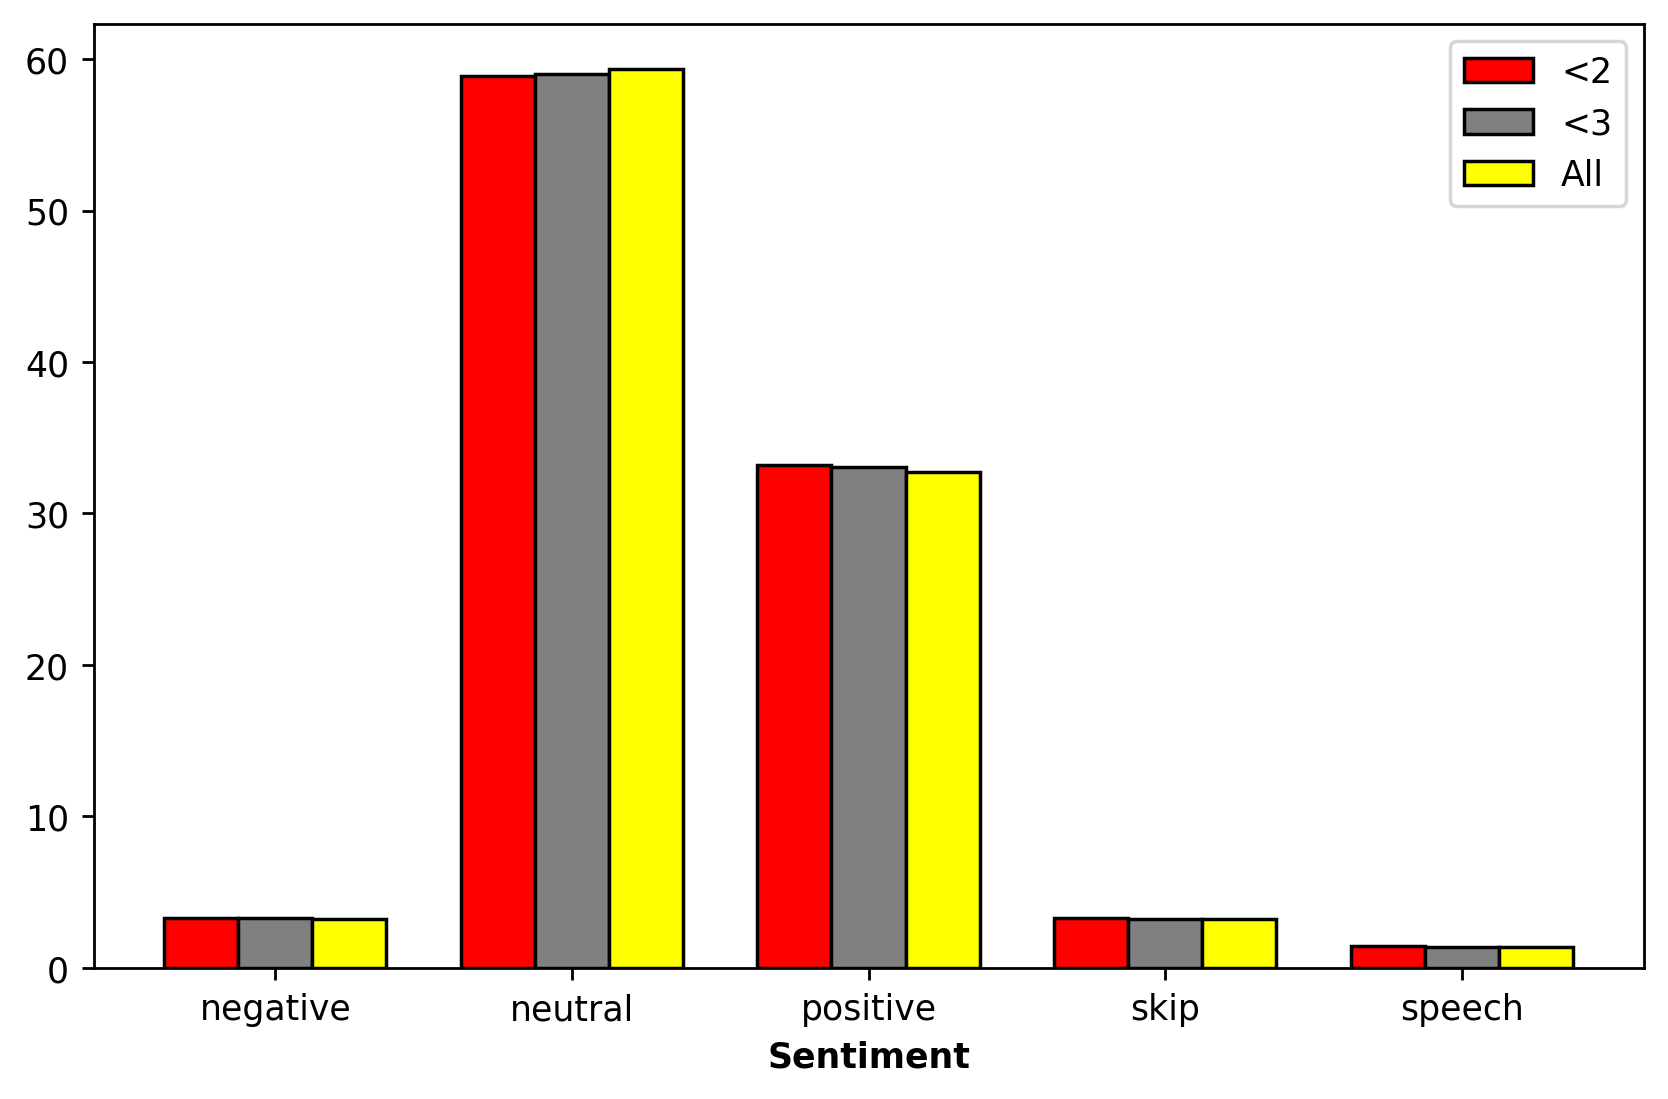

In [279]:
bars_less2 = get_percantage(df_sentiment_counts2['counts'])
bars_less3 = get_percantage(df_sentiment_counts3['counts'])
barsAll = get_percantage(df_sentiment_countsAll['counts'])

get_3_sentiment_bars(bars_less2, bars_less3, barsAll)

We can see that the number of comments from authors does not affect the percentage of sentiment content

### Number of moods

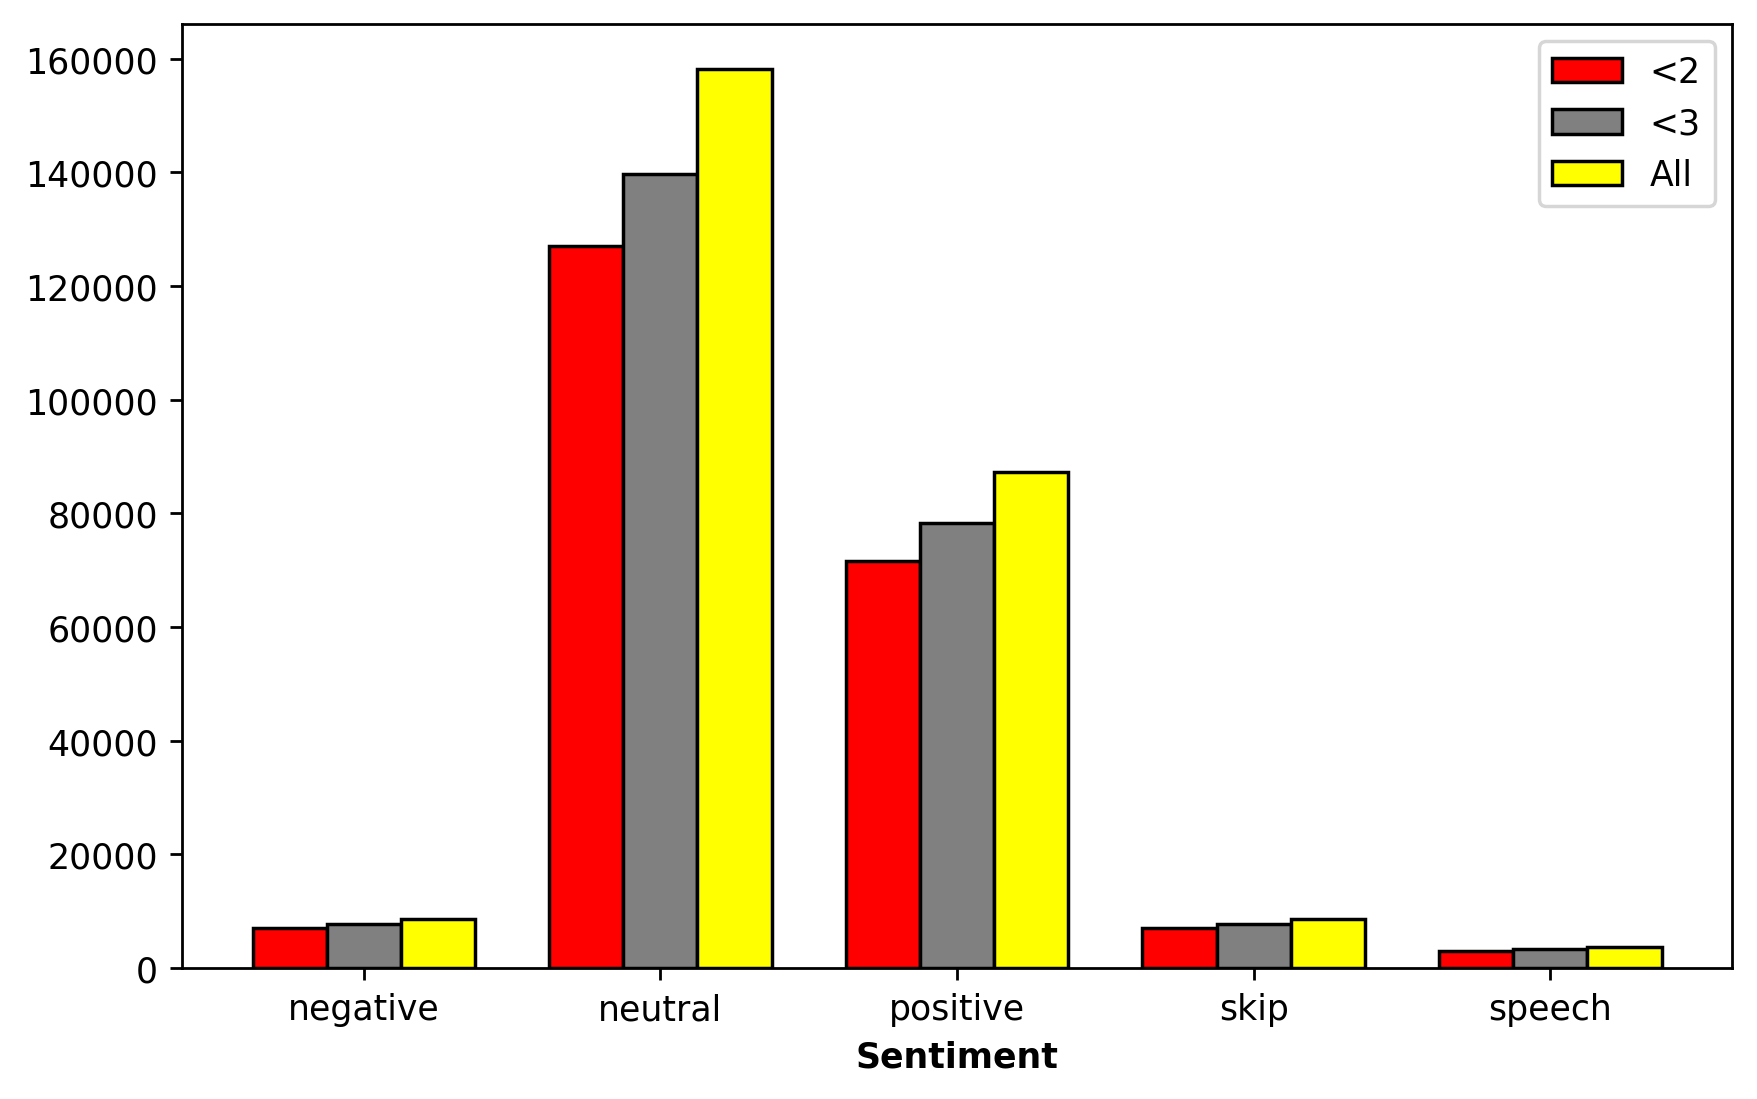

In [280]:
bars_less2 = df_sentiment_counts2['counts'].values
bars_less3 = df_sentiment_counts3['counts'].values
barsAll = df_sentiment_countsAll['counts'].values

get_3_sentiment_bars(bars_less2, bars_less3, barsAll)

# Remove spammers and bots

In [281]:
# if one author wrote the same comments, he will be added to the black list
black_list = df[df.duplicated(['Comments','author'], keep=False )]['author'] 
black_list = black_list.drop_duplicates()

# Remove comments
mask = df['author'].isin(black_list)
df = df[-mask]

### Extra information:
 I tried to detect bots by determining the time interval between their comments. It was not very efficient. The best way that I found to detect bots or spammers is remove authors who have written many comments.

   There is another suggestion to detect bots by analyzing all the comments of all videos on the YouTube channel. This way it will be more accurately detect spammers and bots.

In [282]:
df #260687 rows × 5 columns

,Comments,author,updated Times,char length,word length,sentimensts
0,Кто из 2051?,Seva178,2020-08-26T07:42:33Z,12,3,neutral
1,Моя мечта,Crystal 5000,2020-08-21T23:57:35Z,9,2,positive
2,бомба самчик.........,Ирина Ирина,2020-08-21T14:04:18Z,21,2,skip
3,Вроде бы неделю назад вышел оказывается год назад,Мадияр Кинеев,2020-08-21T12:44:25Z,49,8,neutral
4,Хороший телефон,Эмиль Исаев,2020-08-20T17:10:08Z,15,2,positive
...,...,...,...,...,...,...
266595,Дарова,Foster228 ;D,2019-04-16T10:00:38Z,6,1,speech
266596,Я первый,Валерий Герасименко,2019-04-16T10:00:35Z,8,2,neutral
266597,1,Никита Дедюхин,2019-04-16T10:00:34Z,1,1,neutral
266598,Кайф,ARTHUR SHAKIROV,2019-04-16T10:00:32Z,4,1,positive


### Remove comments

In [283]:
print("The average number of words in a document is: {}.".format(np.mean(df['word length'].values)))
print("The minimum number of words in a document is: {}.".format(min(df['word length'].values)))
print("The maximum number of words in a document is: {}.".format(max(df['word length'].values)))

The average number of words in a document is: 4.962103979101374.
The minimum number of words in a document is: 1.
The maximum number of words in a document is: 662.


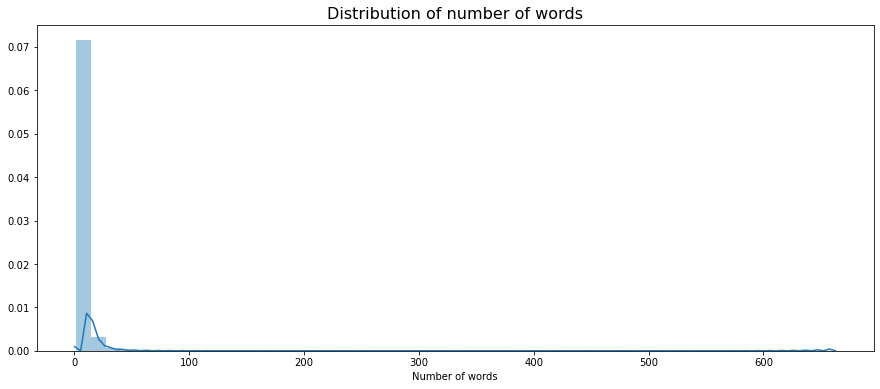

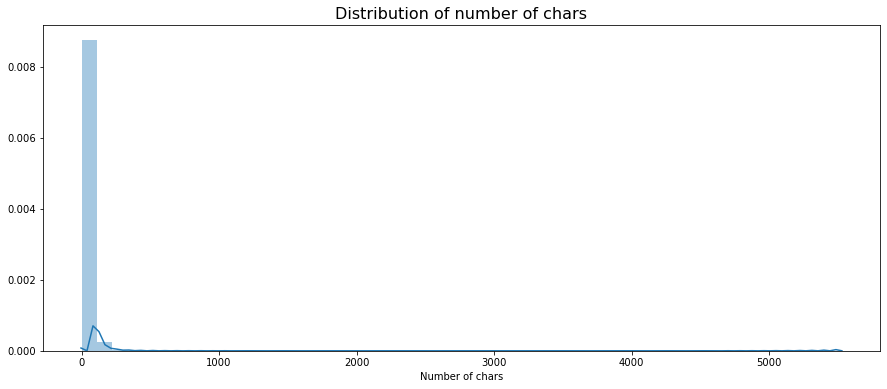

In [284]:
fig, ax = plt.subplots(figsize=(15,6))

ax.set_title("Distribution of number of words", fontsize=16)
ax.set_xlabel("Number of words")
sns.distplot(df['word length'].values, bins=50, ax=ax);

fig, ax = plt.subplots(figsize=(15,6))

ax.set_title("Distribution of number of chars", fontsize=16)
ax.set_xlabel("Number of chars")
sns.distplot(df['char length'].values, bins=50, ax=ax);

In [285]:
mask = (df['char length'] < 3) | (df['char length'] > 1000)

print("There are {} documents with over 1000 and less then 3 chars.".format(sum(mask == True)))

df = df[-mask]

There are 9606 documents with over 1000 and less then 3 chars.


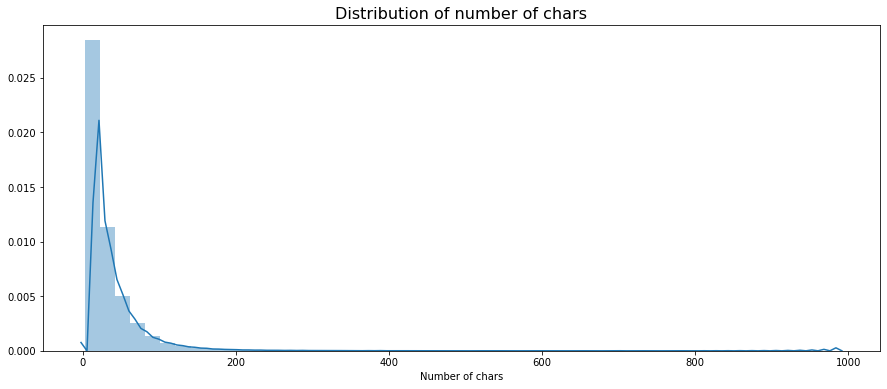

In [287]:
fig, ax = plt.subplots(figsize=(15,6))

ax.set_title("Distribution of number of chars", fontsize=16)
ax.set_xlabel("Number of chars")
sns.distplot(df['char length'].values, bins=50, ax=ax);

In [288]:
print("There are {} comments with over 200 words.".format(sum(df['word length'] > 100)))

mask = df['word length'] > 100
df = df[-mask]
df = df.set_index(np.arange(len(df.index)))

There are 67 comments with over 200 words.


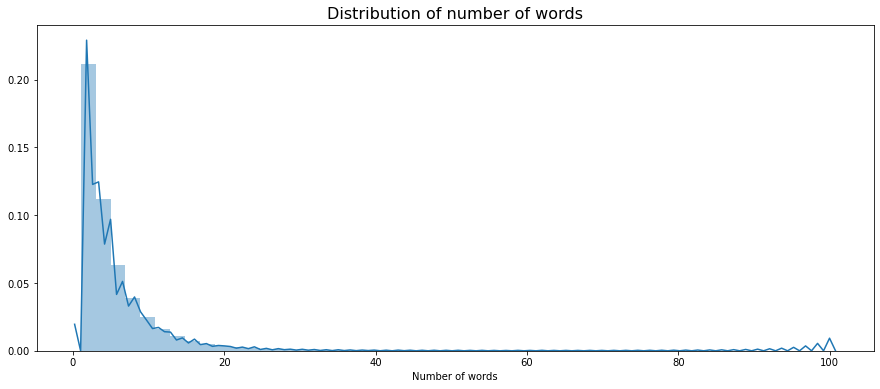

In [289]:
fig, ax = plt.subplots(figsize=(15,6))

ax.set_title("Distribution of number of words", fontsize=16)
ax.set_xlabel("Number of words")
sns.distplot(df['word length'].values, bins=50, ax=ax);

In [290]:
df #251081

,Comments,author,updated Times,char length,word length,sentimensts
0,Кто из 2051?,Seva178,2020-08-26T07:42:33Z,12,3,neutral
1,Моя мечта,Crystal 5000,2020-08-21T23:57:35Z,9,2,positive
2,бомба самчик.........,Ирина Ирина,2020-08-21T14:04:18Z,21,2,skip
3,Вроде бы неделю назад вышел оказывается год назад,Мадияр Кинеев,2020-08-21T12:44:25Z,49,8,neutral
4,Хороший телефон,Эмиль Исаев,2020-08-20T17:10:08Z,15,2,positive
...,...,...,...,...,...,...
251009,Наконец-то!,Viktor 887888,2019-04-16T10:00:41Z,11,1,positive
251010,Дарова,Foster228 ;D,2019-04-16T10:00:38Z,6,1,speech
251011,Я первый,Валерий Герасименко,2019-04-16T10:00:35Z,8,2,neutral
251012,Кайф,ARTHUR SHAKIROV,2019-04-16T10:00:32Z,4,1,positive


# Topic extraction 

Using Elmo embedder 

In [21]:
from deeppavlov.models.embedders.elmo_embedder import ELMoEmbedder
#elmo = ELMoEmbedder("http://files.deeppavlov.ai/deeppavlov_data/elmo_ru-twitter_2013-01_2018-04_600k_steps.tar.gz")


[nltk_data] Downloading package punkt to /home/aigaf/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/aigaf/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package perluniprops to
[nltk_data]     /home/aigaf/nltk_data...
[nltk_data]   Package perluniprops is already up-to-date!
[nltk_data] Downloading package nonbreaking_prefixes to
[nltk_data]     /home/aigaf/nltk_data...
[nltk_data]   Package nonbreaking_prefixes is already up-to-date!


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [46]:
%%time
#matrix = elmo(sents, signature="default", as_dict=True)

CPU times: user 1d 3h 59min 38s, sys: 41min 34s, total: 1d 4h 41min 13s
Wall time: 4h 15min 8s


In [47]:
#with open('ElmoValuesV2.data', 'wb') as filehandle:
    # store the data as binary data stream
#    pickle.dump(matrix, filehandle)

Read matrix values

In [178]:
with open('ElmoValuesV2.data', 'rb') as filehandle:
    # read the data as binary data stream
    matrix = pickle.load(filehandle)

LDA doesn't work with  negative numbers. Trying to fix it

In [180]:
v = [min(i) for i in matrix] 
min_v = min(v)# Looking for a smallest number

In [182]:
%%time
fixed_val = []
for lst in matrix:
    tem_lst = []
    for i in lst:
        tem_lst.append(i + abs(min_v)) # add the smallest number
    fixed_val.append(tem_lst)
    
fixed_val = np.asarray(fixed_val) 

CPU times: user 2min 11s, sys: 5.4 s, total: 2min 16s
Wall time: 2min 16s


In [68]:
#with open('ElmoSentencesV2.data', 'wb') as filehandle:
    # store the data as binary data stream
#    pickle.dump(clean_comments, filehandle)

In [188]:
with open('ElmoSentencesV2.data', 'rb') as filehandle:
    # store the data as binary data stream
    clean_comments = pickle.load(filehandle)

In [192]:
sents = [i.split() for i in clean_comments]

In [195]:
lsa_model = TruncatedSVD(n_components=5)
lsa_topic_matrix = lsa_model.fit_transform(matrix)

### Extract comments after LSA

In [197]:
for i, comp in enumerate(lsa_model.components_):
    vocab_comp = zip(sents, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1])[:5]
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")

Topic 0: 
['дааа', 'давненько', 'я', 'ничего', 'не', 'хотел', 'так', 'как', 'этот', 'девайс'] ['мне', 'нравится', 'самсунг'] ['это', 'очень', 'крутой', 'и', 'современный', 'телефон'] ['«', 'пытаюсь', 'себя', 'заставить', 'поверить', 'в', 'то', 'что', 'он', 'выглядит', 'охренительно', '»'] ['бомба', 'самчик'] 

Topic 1: 
['я', 'не', 'правилно', 'прочитал', 'думал', 'форд', 'галакси'] ['купил', 'в', 'дубае', 'за', 'камера', 'такой', 'шлак', 'как', 'на', 'дешёвых', 'китайских', 'смартфонах', 'уже', 'думаю', 'продать'] ['так', 'я', 'снова', 'пересматриваю', 'и', 'у', 'меня', 'появился', 'вопрос', 'галакси', 'фолд', 'это', 'дяс', 'чем', 'считается', 'планшет', 'или', 'телефон', 'когда', 'открываешь', 'он', 'в', 'развернутом', 'виде', 'тоесть', 'щяс', 'как', 'понять'] ['это', 'орудие', 'убийства'] ['пау', 'пау', 'угораю'] 

Topic 2: 
['ждём', 'от', 'самсунг', 'теперь', 'телевизор', 'дюймов', 'который', 'можно', 'свернуть', 'и', 'в', 'корман', 'убрать'] ['куда', 'уж', 'дальше', 'пойдёт', 'сам

In [ ]:
%%time
df = clean_comments(df)
df = lemmatize(df)

In [124]:
lemmatized_comments = [i for i in df['text lemmatized'].values if i != '']# Remove '' from dataFrame

### Extract topics after LDA

In [174]:
%%time
CountVector = CountVectorizer(analyzer='word', min_df=100, max_df=0.80)
tfIdfVect = TfidfVectorizer(max_df = 0.80, min_df = 100)

X_tfidf = tfIdfVect.fit_transform(lemmatized_comments)
X_count = CountVector.fit_transform(lemmatized_comments)

CPU times: user 2.12 s, sys: 0 ns, total: 2.12 s
Wall time: 2.11 s


In [175]:
%%time
lda_count = LatentDirichletAllocation(n_components=4, random_state=42, n_jobs = 4)
lda_count.fit(X_count)

show_topics(vectorizer=CountVector, lda_model=lda_count, n_words=10)     

CPU times: user 11.5 s, sys: 120 ms, total: 11.6 s
Wall time: 2min 45s


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,телефон,круто,просто,будущее,ждать,раскладушка,давать,супер,бомба,классный
Topic 1,хотеть,крутой,очень,телефон,fold,топ,обзор,аппарат,galaxy,фолд
Topic 2,хороший,интересно,удача,вилс,интересный,повезти,девайс,хотеться,смартфон,штука
Topic 3,выигрывать,самсунг,участвовать,комментарий,валя,экран,технология,класс,год,смотреть


In [176]:
%%time
lda_tfidf = LatentDirichletAllocation(n_components=4, random_state=42, n_jobs = 4)
lda_tfidf.fit(X_tfidf)

show_topics(vectorizer=tfIdfVect, lda_model=lda_tfidf, n_words=10)   

CPU times: user 9.61 s, sys: 149 ms, total: 9.76 s
Wall time: 2min 17s


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,круто,выигрывать,телефон,будущее,давать,супер,ждать,раскладушка,просто,классный
Topic 1,хотеть,крутой,fold,топ,телефон,огонь,аппарат,фолд,galaxy,обзор
Topic 2,удача,хороший,интересно,повезти,вилс,интересный,девайс,привет,хотеться,смартфон
Topic 3,участвовать,самсунг,комментарий,класс,бомба,валя,технология,телефон,новый,айфон


### How we can see extracting the topic is pretty bad for different models
### We can try model BERT  from Deeppavlov + LDA:
#### https://blog.insightdatascience.com/contextual-topic-identification-4291d256a032
    